In [1]:
# This notebook is for creating and testing method on curating datasets on stock trading data for offline reinforcement learning with decision transformer model
# This will get stock data from yahoo finance
# Then it will use the stock data to create gym environments and sample state, action, reward (both randomly or/and by a trained agent ) which then store as a replay buffer
# Group these replay buffers and export as a dataset

In [1]:
# import helper function for getting stock data
from getstock import get_stock_data_yf_between_with_indicators
# import time library
from datetime import datetime, timedelta
# get stock data with technical indicators
stock_name = 'AAPL'

# period of data to get
period = 365*7
train_period = 365*5
# start_date in format 'YYYY-MM-DD'
start_date = '2015-01-01'
# calculate end date being x days after start date
start_date_obj = datetime.strptime(start_date, '%Y-%m-%d')
end_date_obj = start_date_obj + timedelta(days=period)
end_train_date_obj = start_date_obj + timedelta(days=train_period)
end_date = end_date_obj.strftime('%Y-%m-%d')


interval = '1d'
indicators = ['Volume', 'volume_cmf', 'trend_macd', 'momentum_rsi']

stockdata = get_stock_data_yf_between_with_indicators(stock_name, start_date, end_date, interval, indicators)
stockdata_train = get_stock_data_yf_between_with_indicators(stock_name, start_date, end_train_date_obj, interval, indicators)


[*********************100%***********************]  1 of 1 completed


/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


[*********************100%***********************]  1 of 1 completed


/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


In [3]:
import multiprocessing
multiprocessing.log_to_stderr()

<Logger multiprocessing (WARNING)>

In [2]:
# loop through the stock data and check for any NaN values or inf values
import numpy as np
for col in stockdata.columns:
    if stockdata[col].isnull().values.any() or stockdata[col].isin([np.inf, -np.inf]).values.any():
        print(f'Column {col} has NaN or inf values')

In [2]:
# create the gym environment using the stock data
import gym
from TradingEnvClass import StockTradingEnv

init_balance = 10000
max_step = len(stockdata)-1

env = StockTradingEnv(stockdata, init_balance, max_step, random = False)


/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(


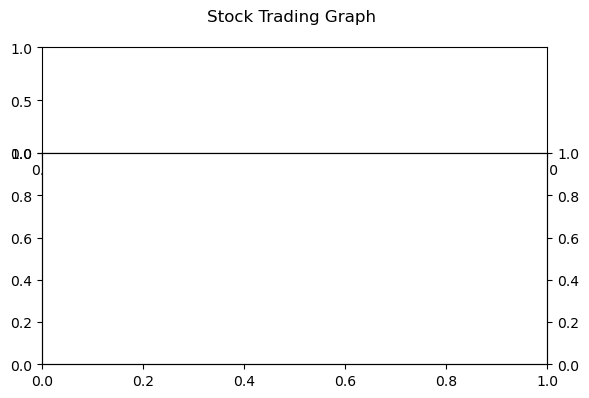

/media/victoru/B612CEC512CE8A37/ai50/pytorch_test/reinforcementlearning/TradingEnvClass.py:425: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.price_ax.set_xticklabels(self.df.index[step_range],rotation=45, horizontalalignment='right')
/media/victoru/B612CEC512CE8A37/ai50/pytorch_test/reinforcementlearning/TradingEnvClass.py:425: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.price_ax.set_xticklabels(self.df.index[step_range],rotation=45, horizontalalignment='right')
/media/victoru/B612CEC512CE8A37/ai50/pytorch_test/reinforcementlearning/TradingEnvClass.py:425: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.price_ax.set_xticklabels(self.df.index[step_range],rotation=45, horizontalalignment='right')
/media/victoru/B612CEC512CE8A37/ai50/pytorch_test/reinforcementlearning/TradingEnvClass.py:425: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.price_ax.

In [3]:
# run the environment with random actions and render the environment\
# this is to check if the environment is working
env.reset()
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    env.render(mode='live')

In [6]:
# create dictionary with state, action, reward as keys and store the values in a list
# then create a huggingface dataset from the dictionary
# then save the huggingface dataset to a file
import numpy as np
from datasets import Dataset as huggingfaceDataset

data = {'data':[]}

/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# create a loop to sample state, action, reward and store in the dictionary
num_episodes = 1000
for i in range(num_episodes):
    # create list for storing state, action, reward
    dict = {'state': [], 'action': [], 'reward': [], 'timestep': []}
    # reset the environment
    env.reset()
    state = env.render(mode='None')
    dict['state'].append(state.tolist())
    timestep = 0
    done = False
    # create a loop to sample action, next_state, reward and store in the dictionary
    while not done:
        # sample action
        action = env.action_space.sample()
        _, reward, done, info = env.step(action)
        next_state = env.render(mode='None')
        # store state, action, reward in the dictionary
        dict['action'].append(action.tolist())
        dict['reward'].append([reward])
        dict['timestep'].append(timestep)
        # update state
        timestep += 1
        state = next_state
        # check if done
        if done:
            print('Episode: ', i, 'Timestep: ', timestep)
            break
        else:
            dict['state'].append(state.tolist())
    
    # store the state, action, reward list in the dictionary
    data['data'].append(dict)


Episode:  0 Timestep:  1761
Episode:  1 Timestep:  1761
Episode:  2 Timestep:  1761
Episode:  3 Timestep:  1761
Episode:  4 Timestep:  1761
Episode:  5 Timestep:  1761
Episode:  6 Timestep:  1761
Episode:  7 Timestep:  1761
Episode:  8 Timestep:  1761
Episode:  9 Timestep:  1761
Episode:  10 Timestep:  1761
Episode:  11 Timestep:  1761
Episode:  12 Timestep:  1761
Episode:  13 Timestep:  1761
Episode:  14 Timestep:  1761
Episode:  15 Timestep:  1761


KeyboardInterrupt: 

In [7]:
file_name = stock_name + '_' + str(period) + '_' + str(start_date) + '_' + str(interval) + '_random_replaybuffer.json'
# output the dictionary to a json file
import json
with open(file_name, 'w') as fp:
    json.dump(data, fp)

In [8]:
# train an agent using stable baselines
# import 
# import stable baselines
import torch
# set detect anomaly to true to get more information on the error
torch.autograd.set_detect_anomaly(True)
import torch.nn as nn

from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3 import DDPG

from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# create a custom SubprocVecEnv class to allow rendering of the environment according to the custom render function
class CustomSubprocVecEnv(SubprocVecEnv):
    def __init__(self, env_fns):
        super().__init__(env_fns)
        self.current_env = 0 # index of the current environment to render

    def render(self, print=False):
        # create an empty numpy array to store the rendered observations
        obs_list = []
        # loop through all the remote objects
        for remote in self.remotes:
            # send a render command with the print argument to the remote object
            remote.send(('render', print))
            # receive the rendered observation
            obs = remote.recv()
            """
            # show the image using matplotlib if not None
            if img is not None:
                import matplotlib.pyplot as plt
                plt.imshow(img)
                plt.show()
            """
            # append the observation to the list
            obs_list.append(obs)
        # return the observation
        return obs_list


In [6]:
# check pytorch version
print(torch.__version__)


1.11.0


In [9]:
# create the environment as a subprocesses vectorized environment for stable baselines training
num_cpu = 6
env_stable = CustomSubprocVecEnv([lambda: StockTradingEnv(stockdata_train, init_balance, len(stockdata_train)-1, random = False) for i in range(num_cpu)])

# check for nan or inf in the environment
# env_stable = VecCheckNan(env_stable, raise_exception=True)

env_stable_dum = DummyVecEnv([lambda: StockTradingEnv(stockdata_train, init_balance, len(stockdata_train)-1, random = False)])

/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(
/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(


/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(
/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(
/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(
/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(
/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(


In [10]:
# create the models
modelPPO = PPO("MlpPolicy", env_stable, verbose=1)
modelA2C = A2C("MlpPolicy", env_stable, verbose=1)
modelDDPG = DDPG("MlpPolicy", env_stable_dum, verbose=1)
# store the models' name in a list
model_list = [modelPPO, modelA2C, modelDDPG]

Using cuda device
Using cuda device
Using cuda device


In [11]:
# evaluate the models
for model in model_list:
    if model != modelDDPG:
        mean_reward, std_reward = evaluate_policy(model, env_stable, n_eval_episodes=10)
    else:
        mean_reward, std_reward = evaluate_policy(model, env_stable_dum, n_eval_episodes=10)
    print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:3770000.00 +/- 0.00
mean_reward:3770000.00 +/- 0.00
mean_reward:3770000.00 +/- 0.00


In [12]:
# train the models
for model in model_list:
    
    print('Training model: ', model)
    model.learn(total_timesteps=len(stockdata_train)*20)
    print('Model trained')


        

Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7fb8a48aee30>
------------------------------
| time/              |       |
|    fps             | 5459  |
|    iterations      | 1     |
|    time_elapsed    | 2     |
|    total_timesteps | 12288 |
------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1034          |
|    iterations           | 2             |
|    time_elapsed         | 23            |
|    total_timesteps      | 24576         |
| train/                  |               |
|    approx_kl            | 0.00011913368 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.84         |
|    explained_variance   | 3.34e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.84e+09      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000596     |
|    

In [13]:
# evaluate the models
for model in model_list:
    if model != modelDDPG:
        mean_reward, std_reward = evaluate_policy(model, env_stable, n_eval_episodes=10, deterministic=False)
    else:
        mean_reward, std_reward = evaluate_policy(model, env_stable_dum, n_eval_episodes=10, deterministic=False)
    print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:2600886.61 +/- 346832.63
mean_reward:4581287.13 +/- 916895.10
mean_reward:6665752.31 +/- 0.00


In [22]:
# test run the model on env_stable
obs = env_stable.reset()


action, _states = modelPPO.predict(obs)
obs, rewards, done, info = env_stable.step(action)
statearray = np.asarray(env_stable.render(mode='None'))


# check the shape of state
print("shape of state: ", statearray)


shape of state:  [[ 2.56525002e+01  2.63425007e+01  2.55000000e+01  2.63374996e+01
   3.88948754e-01  1.79479876e-03  1.00000000e+02  1.00000000e+04
   1.00000000e+04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.56525002e+01  2.63425007e+01  2.55000000e+01  2.63374996e+01
   3.88948754e-01  1.79479876e-03  1.00000000e+02  1.00263150e+04
   1.00000000e+04 -1.00000000e+00  0.00000000e+00  1.00000000e+00
   2.63150005e+01]
 [ 2.56525002e+01  2.63425007e+01  2.55000000e+01  2.63374996e+01
   3.88948754e-01  1.79479876e-03  1.00000000e+02  6.47378993e+03
   1.00000000e+04  1.34000000e+02  2.63150005e+01  0.00000000e+00
   0.00000000e+00]
 [ 2.56525002e+01  2.63425007e+01  2.55000000e+01  2.63374996e+01
   3.88948754e-01  1.79479876e-03  1.00000000e+02  1.00000000e+04
   1.00000000e+04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.56525002e+01  2.63425007e+01  2.55000000e+01  2.63374996e+01
   3.88948754e-01  1.79479876e-03  1.00000000e+02

In [23]:
print(rewards.shape)

(6,)


In [18]:
print(action[0,:])

[-0.9135959  0.6192283]


In [13]:
# multiprocess
# create a loop to sample state, action from the each models, reward and store in the dictionary
output = []
num_episodes = 500
keys = ['state', 'action', 'reward', 'timestep']
# loop through the models
for model in model_list:
    data2 = {'data':[]}
    for num_ep in range(num_episodes):
        # create list of dicts in num_cpu for storing state, action, reward
        dicts = [{key:[] for key in keys} for i in range(num_cpu)]

        # reset the environment
        state = env_stable.reset()
        # get state as np array from env_stable
        statearray = np.asarray(env_stable.render(mode='None'))
        # loop through both statearray and dicts
        for i, dict in zip(range(statearray.shape[0]), dicts):
            dict['state'].append(statearray[i,:].tolist())
        timestep = 0
        # create the first done check
        done = np.asarray([False for i in range(num_cpu)])
        # create a loop to sample action, next_state, reward and store in the dictionary
        while True:
            # sample action
            action, _states = model.predict(state, deterministic=False)
            state, reward, done, info = env_stable.step(action)
            next_state = np.asarray(env_stable.render(mode='None'))
            # store state, action, reward in the dictionary
            for i,dict in zip(range(statearray.shape[0]), dicts):
                # check if the environment is done
                if not done[i]:
                    dict['action'].append(action[i,:].tolist())
                    dict['reward'].append([reward[i]])
                    dict['timestep'].append(timestep)
            # update state
            timestep += 1
            state = next_state
            # check if all environment is done
            if done.all():
                print('Episode: ', num_ep, 'Timestep: ', timestep)
                break
            else:
                for i, dict in zip(range(statearray.shape[0]), dicts):
                    if not done[i]:
                        dict['state'].append(statearray[i,:].tolist())
        
        # store the state, action, reward list in the dictionary
    data2['data'].append(dict)
    output.append(data2)

Episode:  0 Timestep:  753
Episode:  1 Timestep:  753
Episode:  2 Timestep:  753
Episode:  3 Timestep:  753
Episode:  4 Timestep:  753
Episode:  5 Timestep:  753
Episode:  6 Timestep:  753
Episode:  7 Timestep:  753
Episode:  8 Timestep:  753
Episode:  9 Timestep:  753
Episode:  10 Timestep:  753
Episode:  11 Timestep:  753
Episode:  12 Timestep:  753
Episode:  13 Timestep:  753
Episode:  14 Timestep:  753
Episode:  15 Timestep:  753
Episode:  16 Timestep:  753
Episode:  17 Timestep:  753
Episode:  18 Timestep:  753
Episode:  19 Timestep:  753
Episode:  20 Timestep:  753
Episode:  21 Timestep:  753
Episode:  22 Timestep:  753
Episode:  23 Timestep:  753
Episode:  24 Timestep:  753
Episode:  25 Timestep:  753
Episode:  26 Timestep:  753
Episode:  27 Timestep:  753
Episode:  28 Timestep:  753
Episode:  29 Timestep:  753
Episode:  30 Timestep:  753
Episode:  31 Timestep:  753
Episode:  32 Timestep:  753
Episode:  33 Timestep:  753
Episode:  34 Timestep:  753
Episode:  35 Timestep:  753
Ep

In [14]:
# single process
# create a loop to sample state, action from the each models, reward and store in the dictionary
output = []
num_episodes = 500
# loop through the models
for model in model_list:
    data2 = {'data':[]}
    for i in range(num_episodes):
        # create list for storing state, action, reward
        dict = {'state': [], 'action': [], 'reward': [], 'timestep': []}
        # reset the environment
        env.reset()
        state = env.render(mode='None')
        dict['state'].append(state.tolist())
        timestep = 0
        done = False
        # create a loop to sample action, next_state, reward and store in the dictionary
        while not done:
            # sample action
            action, _states = model.predict(state, deterministic=False)
            _, reward, done, info = env.step(action)
            next_state = env.render(mode='None')
            # store state, action, reward in the dictionary
            dict['action'].append(action.tolist())
            dict['reward'].append([reward])
            dict['timestep'].append(timestep)
            # update state
            timestep += 1
            state = next_state
            # check if done
            if done:
                print('Episode: ', i, 'Timestep: ', timestep)
                break
            else:
                dict['state'].append(state.tolist())
        
        # store the state, action, reward list in the dictionary
    data2['data'].append(dict)
    output.append(data2)

Episode:  0 Timestep:  1509
Episode:  1 Timestep:  1509
Episode:  2 Timestep:  1509
Episode:  3 Timestep:  1509
Episode:  4 Timestep:  1509
Episode:  5 Timestep:  1509
Episode:  6 Timestep:  1509
Episode:  7 Timestep:  1509
Episode:  8 Timestep:  1509
Episode:  9 Timestep:  1509
Episode:  10 Timestep:  1509
Episode:  11 Timestep:  1509
Episode:  12 Timestep:  1509
Episode:  13 Timestep:  1509
Episode:  14 Timestep:  1509
Episode:  15 Timestep:  1509
Episode:  16 Timestep:  1509
Episode:  17 Timestep:  1509
Episode:  18 Timestep:  1509
Episode:  19 Timestep:  1509
Episode:  20 Timestep:  1509
Episode:  21 Timestep:  1509
Episode:  22 Timestep:  1509
Episode:  23 Timestep:  1509
Episode:  24 Timestep:  1509
Episode:  25 Timestep:  1509
Episode:  26 Timestep:  1509
Episode:  27 Timestep:  1509
Episode:  28 Timestep:  1509
Episode:  29 Timestep:  1509
Episode:  30 Timestep:  1509
Episode:  31 Timestep:  1509
Episode:  32 Timestep:  1509
Episode:  33 Timestep:  1509
Episode:  34 Timestep:  

In [19]:
# loop through the output list and save each dictionary to a json file
for i in range(len(output)):
    file_name = stock_name + '_' + str(period) + '_' + start_date + '_' + interval + '_' + model_list[i].__class__.__name__ + '_replaybuffer.json'
    # output the dictionary to a json file
    import json

    with open(file_name, 'w') as fp:
        json.dump(output[i], fp)
    